<a href="https://colab.research.google.com/github/finlytics-hub/marketing_analytics-customer_churn/blob/master/Customer_Churn_Model_Binary_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score, f1_score, accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier

In [0]:
# Import data set
telco = pd.read_csv("/content/drive/My Drive/Finlytics Hub/Data Science/Customer Analytics/Telco_Churn.csv")

## Exploratory Data Analysis

In [15]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Account_Length  3333 non-null   int64  
 1   Vmail_Message   3333 non-null   int64  
 2   Day_Mins        3333 non-null   float64
 3   Eve_Mins        3333 non-null   float64
 4   Night_Mins      3333 non-null   float64
 5   Intl_Mins       3333 non-null   float64
 6   CustServ_Calls  3333 non-null   int64  
 7   Churn           3333 non-null   object 
 8   Intl_Plan       3333 non-null   object 
 9   Vmail_Plan      3333 non-null   object 
 10  Day_Calls       3333 non-null   int64  
 11  Day_Charge      3333 non-null   float64
 12  Eve_Calls       3333 non-null   int64  
 13  Eve_Charge      3333 non-null   float64
 14  Night_Calls     3333 non-null   int64  
 15  Night_Charge    3333 non-null   float64
 16  Intl_Calls      3333 non-null   int64  
 17  Intl_Charge     3333 non-null   f

In [0]:
telco["Churn"].value_counts()

no     2850
yes     483
Name: Churn, dtype: int64

In [0]:
# Group telco by 'Churn' and compute the mean of CustServ_Calls and Vmail_Message
print(telco.groupby("Churn")[["CustServ_Calls", "Vmail_Message"]].mean())

       CustServ_Calls  Vmail_Message
Churn                               
no           1.449825       8.604561
yes          2.229814       5.115942


In [0]:
# Group telco by 'Churn' and compute the standard deviation of CustServ_Calls and Vmail_Message
print(telco.groupby("Churn")[["CustServ_Calls", "Vmail_Message"]].std())

       CustServ_Calls  Vmail_Message
Churn                               
no           1.163883      13.913125
yes          1.853275      11.860138


In [0]:
# Count the number of churners and non-churners by State
print(telco.groupby('State')['Churn'].value_counts())

State  Churn
AK     no       49
       yes       3
AL     no       72
       yes       8
AR     no       44
                ..
WI     yes       7
WV     no       96
       yes      10
WY     no       68
       yes       9
Name: Churn, Length: 102, dtype: int64


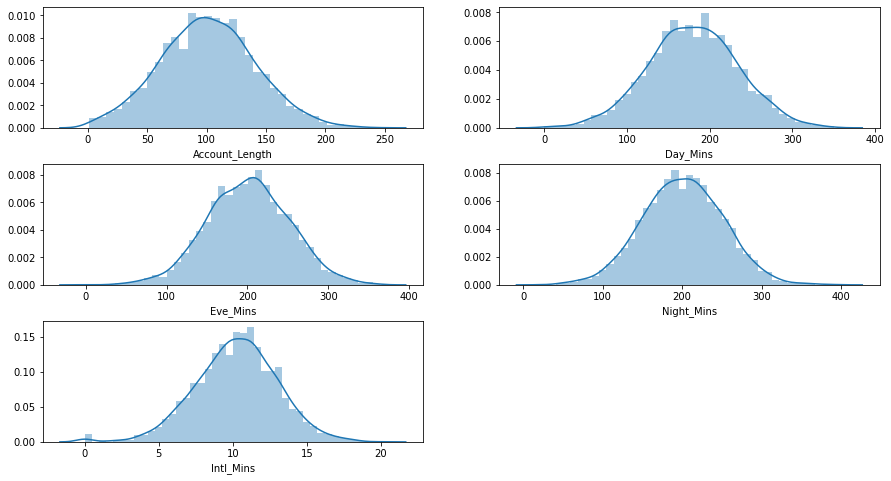

In [0]:
# Visualize the distribution of five features
fig = plt.figure(figsize = (15,8))
plt.subplot(3, 2, 1, xlabel = "Account Length")
sns.distplot(telco["Account_Length"])
plt.subplot(3, 2, 2, xlabel = "Day Mins")
sns.distplot(telco["Day_Mins"])
plt.subplot(3, 2, 3, xlabel = "Evening Minutes")
sns.distplot(telco["Eve_Mins"])
plt.subplot(3, 2, 4, xlabel = "Night Minutes")
sns.distplot(telco["Night_Mins"])
plt.subplot(3, 2, 5, xlabel = "International Minutes")
sns.distplot(telco["Intl_Mins"])
plt.subplots_adjust(hspace = 0.3) # Increase the vertical space between subplots so that the x labels can be visible
plt.show()

All appear to be more or less normally distributed, therefore no feature transformation is required. If this was not the case, then we could have explored some transformations (MinMax scaling, normalization, binning, etc.) to improve our model accuracy.

In [0]:
# Group telco by 'Churn' and compute the mean of Account_Length
print(telco.groupby("Churn")[['Account_Length']].mean())

       Account_Length
Churn                
no         100.793684
yes        102.664596


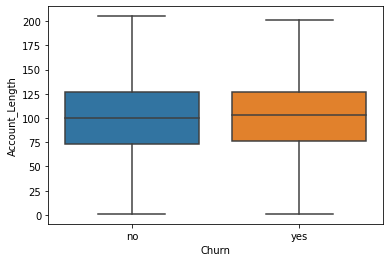

In [0]:
# Visualize Account_Length between churners and non-churners
sns.boxplot(x = 'Churn', y = 'Account_Length', data = telco, sym = "")
plt.show()

This is pretty strange as the Account_Length does not appear to be correlated with a customer's churn!

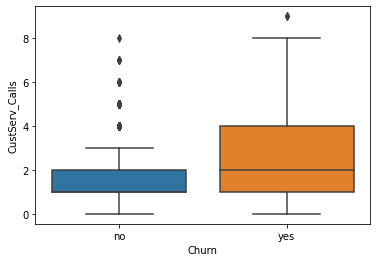

In [0]:
# Visualise distribution
sns.boxplot(x = 'Churn', y = 'CustServ_Calls', data = telco)
plt.show()

Quite a visible distribution of count of customer service calls between churners and non-churners with churners also having a few outliers.

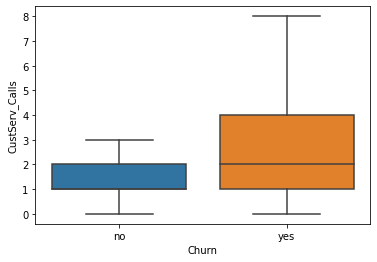

In [0]:
# Visualise distribution after excluding outliers from the boxplot
sns.boxplot(x = 'Churn', y = 'CustServ_Calls', data = telco, sym = "")
plt.show()

Looks like churners make more customer service calls

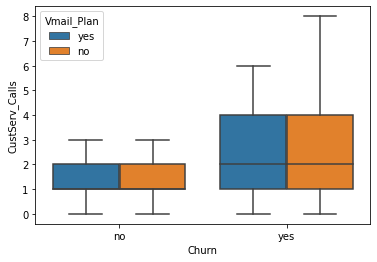

In [0]:
# Visualise distribution excluding outliers with a third parameter for voice mail plan
sns.boxplot(x = 'Churn', y = 'CustServ_Calls', data = telco, hue = "Vmail_Plan", sym = "")
plt.show()

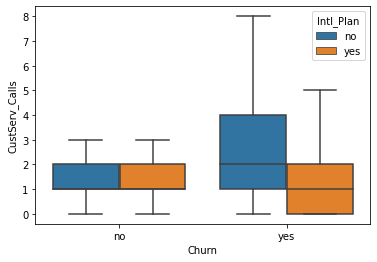

In [0]:
# Not much of a difference between presence of a voice mail plan or not. Let's retry with international plan instead of voice mail plan
# Visualise distribution excluding outliers with a third parameter for voice mail plan
sns.boxplot(x = 'Churn', y = 'CustServ_Calls', data = telco, hue = "Intl_Plan", sym = "")
plt.show()

Looks like churners with international plan make more customer service calls while those churners with no international plan make fewer customer service calls.

## Data Preprocessing

In [16]:
# Encoding binary features

# Replace 'no' with 0 and 'yes' with 1 in 'Vmail_Plan'
telco['Vmail_Plan'] = telco['Vmail_Plan'].replace({"no": 0, "yes": 1})

# Replace 'no' with 0 and 'yes' with 1 in 'Intl_Plan'
telco['Intl_Plan'] = telco['Intl_Plan'].replace({"no": 0, "yes": 1})

# Replace 'no' with 0 and 'yes' with 1 in 'Churn'
telco['Churn'] = telco['Churn'].replace({"no": 0, "yes": 1})

# Print the results to verify
print(telco['Intl_Plan'].head())
print(telco['Vmail_Plan'].head())
print(telco['Churn'].head())

0    0
1    0
2    0
3    1
4    1
Name: Intl_Plan, dtype: int64
0    1
1    1
2    0
3    0
4    0
Name: Vmail_Plan, dtype: int64
0    0
1    0
2    0
3    0
4    0
Name: Churn, dtype: int64


In [17]:
# One hot encoding the State feature
telco = pd.get_dummies(telco, columns = ["State"], drop_first = True)
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 70 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Account_Length  3333 non-null   int64  
 1   Vmail_Message   3333 non-null   int64  
 2   Day_Mins        3333 non-null   float64
 3   Eve_Mins        3333 non-null   float64
 4   Night_Mins      3333 non-null   float64
 5   Intl_Mins       3333 non-null   float64
 6   CustServ_Calls  3333 non-null   int64  
 7   Churn           3333 non-null   int64  
 8   Intl_Plan       3333 non-null   int64  
 9   Vmail_Plan      3333 non-null   int64  
 10  Day_Calls       3333 non-null   int64  
 11  Day_Charge      3333 non-null   float64
 12  Eve_Calls       3333 non-null   int64  
 13  Eve_Charge      3333 non-null   float64
 14  Night_Calls     3333 non-null   int64  
 15  Night_Charge    3333 non-null   float64
 16  Intl_Calls      3333 non-null   int64  
 17  Intl_Charge     3333 non-null   f

## Feature Selection and Feature Engineering

In [0]:
# Drop the unnecessary features
telco = telco.drop(["Area_Code", "Phone"], axis = 1)

In [0]:
# Adding new features
telco['Total_Mins'] = telco["Night_Mins"] + telco["Eve_Mins"] + telco["Day_Mins"] + telco["Intl_Mins"]
telco['Total_Charge'] = telco["Night_Charge"] + telco["Eve_Charge"] + telco["Day_Charge"] + telco["Intl_Charge"]
telco['Total_Calls'] = telco["Night_Calls"] + telco["Eve_Calls"] + telco["Day_Calls"] + telco["Intl_Calls"]
telco["Min_Call"] = telco["Total_Mins"] / telco["Total_Calls"]
telco["Cost_Call"] = telco["Total_Charge"] / telco["Total_Calls"]

In [0]:
# get column values for correlations
telco.columns.values

array(['Account_Length', 'Vmail_Message', 'Day_Mins', 'Eve_Mins',
       'Night_Mins', 'Intl_Mins', 'CustServ_Calls', 'Churn', 'Intl_Plan',
       'Vmail_Plan', 'Day_Calls', 'Day_Charge', 'Eve_Calls', 'Eve_Charge',
       'Night_Calls', 'Night_Charge', 'Intl_Calls', 'Intl_Charge',
       'State_AL', 'State_AR', 'State_AZ', 'State_CA', 'State_CO',
       'State_CT', 'State_DC', 'State_DE', 'State_FL', 'State_GA',
       'State_HI', 'State_IA', 'State_ID', 'State_IL', 'State_IN',
       'State_KS', 'State_KY', 'State_LA', 'State_MA', 'State_MD',
       'State_ME', 'State_MI', 'State_MN', 'State_MO', 'State_MS',
       'State_MT', 'State_NC', 'State_ND', 'State_NE', 'State_NH',
       'State_NJ', 'State_NM', 'State_NV', 'State_NY', 'State_OH',
       'State_OK', 'State_OR', 'State_PA', 'State_RI', 'State_SC',
       'State_SD', 'State_TN', 'State_TX', 'State_UT', 'State_VA',
       'State_VT', 'State_WA', 'State_WI', 'State_WV', 'State_WY',
       'Total_Mins', 'Total_Charge', 'Total_Call

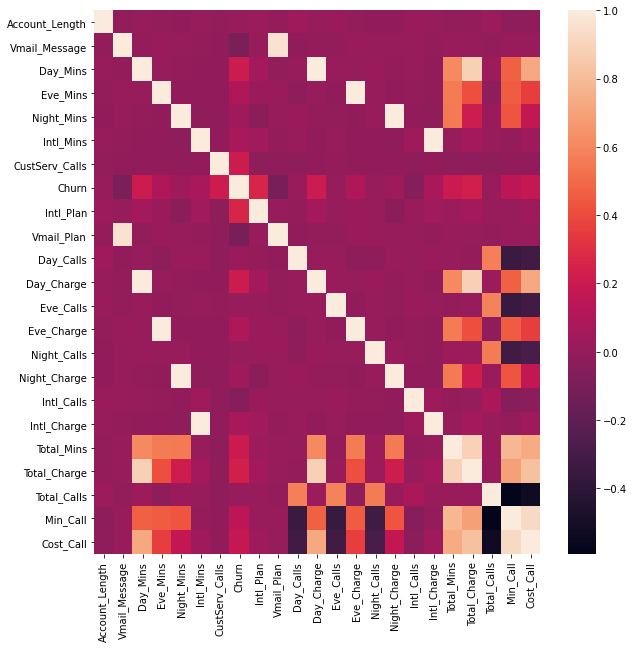

In [0]:
# Checking correlations and detecting multicollinearity amongst all columns other than State
features = ['Account_Length', 'Vmail_Message', 'Day_Mins', 'Eve_Mins', 'Night_Mins', 'Intl_Mins', 'CustServ_Calls', 'Churn', 'Intl_Plan', 'Vmail_Plan', 
            'Day_Calls', 'Day_Charge', 'Eve_Calls', 'Eve_Charge', 'Night_Calls', 'Night_Charge', 'Intl_Calls', 'Intl_Charge', 'Total_Mins', 'Total_Charge', 
            'Total_Calls', 'Min_Call', 'Cost_Call']
telco_corr = telco[features]
corrmat = telco_corr.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corrmat)

In [0]:
# We will drop the following columns due to their high collinearity
columns_drop = ["Vmail_Plan", "Day_Charge", "Eve_Charge", "Night_Charge", "Intl_Charge", "Total_Charge","Total_Mins"]
telco = telco.drop(columns = columns_drop, axis = 1)

In [21]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 66 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Account_Length  3333 non-null   int64  
 1   Vmail_Message   3333 non-null   int64  
 2   Day_Mins        3333 non-null   float64
 3   Eve_Mins        3333 non-null   float64
 4   Night_Mins      3333 non-null   float64
 5   Intl_Mins       3333 non-null   float64
 6   CustServ_Calls  3333 non-null   int64  
 7   Churn           3333 non-null   int64  
 8   Intl_Plan       3333 non-null   int64  
 9   Day_Calls       3333 non-null   int64  
 10  Eve_Calls       3333 non-null   int64  
 11  Night_Calls     3333 non-null   int64  
 12  Intl_Calls      3333 non-null   int64  
 13  State_AL        3333 non-null   uint8  
 14  State_AR        3333 non-null   uint8  
 15  State_AZ        3333 non-null   uint8  
 16  State_CA        3333 non-null   uint8  
 17  State_CO        3333 non-null   u

## Churn Predictions

In [0]:
# Create feature variable
X = telco.drop('Churn', axis=1)
# Create target variable
y = telco['Churn']
# Create training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [0]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2666, 65)
(2666,)
(667, 65)
(667,)


### Logistic Regression Model

Model Training & Predictions

In [0]:
# Instantiate the classifier
lr = LogisticRegression(max_iter = 10000)
# Fit the classifier
lr.fit(X_train, y_train)
# Predict the labels of the test set
y_pred = lr.predict(X_test)
# Predict the probabilities of the test set
y_pred_prob = lr.predict_proba(X_test)

Model Validation

[[552  14]
 [ 84  17]]


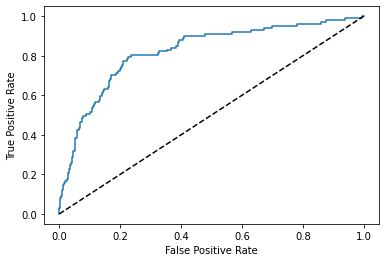

Area under the ROC Curve for the Logistic Regression Model is: 0.82
Gini for the Logistic Regression Model is: 0.64
F1 Score for the Logistic Regression Model is: 0.26


In [0]:
# Print the confusion matrix
print(confusion_matrix(y_test, y_pred))

# Calculate the roc metrics
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[: ][: , 1])
# Plot the ROC curve
plt.plot(fpr, tpr)
# Add labels and diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], "k--")
plt.show()

# Calculate AUROC
AUROC_LR = roc_auc_score(y_test, y_pred_prob[: ][: , 1])
print("Area under the ROC Curve for the Logistic Regression Model is:", "{:.2f}".format(AUROC_LR))

# Calculate Gini
Gini_LR = AUROC_LR * 2 - 1
print("Gini for the Logistic Regression Model is:", "{:.2f}".format(Gini_LR))

# Calculate F1 score
F1_LR = f1_score(y_test, y_pred)
print("F1 Score for the Logistic Regression Model is:", "{:.2f}".format(F1_LR))

### Decision Tree

Model Training & Predictions

In [0]:
# Instantiate the classifier
dtree = DecisionTreeClassifier()
# Fit the classifier
dtree.fit(X_train, y_train)
# Predict the labels of the test set
y_pred_dtree = dtree.predict(X_test)
# Predict the probabilities of the test set
y_pred_prob_dtree = dtree.predict_proba(X_test)

Model Validation

[[536  30]
 [ 24  77]]


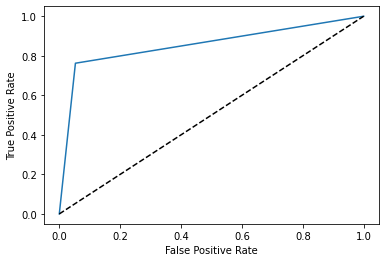

Area under the ROC Curve the Decision Tree Model is: 0.85
Gini for the Decision Tree Model is: 0.71
F1 Score for the Decision Tree Model is: 0.74


In [0]:
# Print the confusion matrix
print(confusion_matrix(y_test, y_pred_dtree))

# Calculate the roc metrics
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_dtree[: ][: , 1])
# Plot the ROC curve
plt.plot(fpr, tpr)
# Add labels and diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], "k--")
plt.show()

# Calculate AUROC
AUROC_DT = roc_auc_score(y_test, y_pred_prob_dtree[: ][: , 1])
print("Area under the ROC Curve the Decision Tree Model is:", "{:.2f}".format(AUROC_DT))

# Calculate Gini
Gini_DT = AUROC_DT * 2 - 1
print("Gini for the Decision Tree Model is:", "{:.2f}".format(Gini_DT))

# Calculate F1 score
F1_DT = f1_score(y_test, y_pred_dtree)
print("F1 Score for the Decision Tree Model is:", "{:.2f}".format(F1_DT))

### Random Forest

Model Training and Predictions

In [0]:
# Instantiate the classifier
rf = RandomForestClassifier()
# Fit to the training data
rf.fit(X_train, y_train)
# Predict the labels of the test set
y_pred_rf = rf.predict(X_test)
# Predict the probabilities of the test set
y_pred_prob_rf = rf.predict_proba(X_test)

Model Validation

[[564   2]
 [ 45  56]]


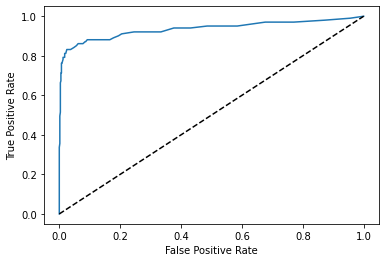

Area under the ROC Curve the Random Forest Model is: 0.94
Gini for the Random Forest Model is: 0.87
F1 Score for the Random Forest Model is: 0.70


In [0]:
# Print the confusion matrix
print(confusion_matrix(y_test, y_pred_rf))

# Calculate the roc metrics
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_rf[: ][: , 1])
# Plot the ROC curve
plt.plot(fpr, tpr)
# Add labels and diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], "k--")
plt.show()

# Calculate AUROC
AUROC_RF = roc_auc_score(y_test, y_pred_prob_rf[: ][: , 1])
print("Area under the ROC Curve the Random Forest Model is:", "{:.2f}".format(AUROC_RF))

# Calculate Gini
Gini_RF = AUROC_RF * 2 - 1
print("Gini for the Random Forest Model is:", "{:.2f}".format(Gini_RF))

# Calculate F1 score
F1_RF = f1_score(y_test, y_pred_rf)
print("F1 Score for the Random Forest Model is:", "{:.2f}".format(F1_RF))

Hyperparameterization for Random Forest

In [0]:
# Create the hyperparameter grid
param_grid = {"n_estimators": [180, 182, 185], #182 was the ideal after repeated trial and errors
              "min_samples_split": [2, 4, 6, 8],
              "min_samples_leaf": [1, 2, 3]}
# Call GridSearchCV
grid_search = GridSearchCV(rf, param_grid, scoring = "roc_auc") # using the default 5 fold validation
# Fit the model
grid_search.fit(X_train, y_train)
# Print the optimal parameters
print(grid_search.best_params_)

{'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 180}


In [0]:
# Predict the labels of the test set
y_pred_grid = grid_search.predict(X_test)
# Predict the probabilities of the test set
y_pred_prob_grid = grid_search.predict_proba(X_test)

[[564   2]
 [ 38  63]]


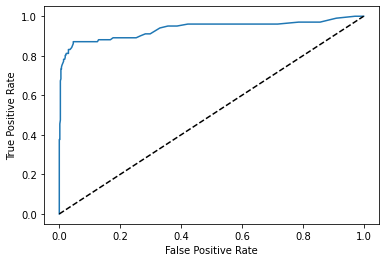

Area under the ROC Curve the Random Forest Model is: 0.94
Gini for the Random Forest Model is: 0.87
F1 Score for the Random Forest Model is: 0.76


In [0]:
# Print the confusion matrix
print(confusion_matrix(y_test, y_pred_grid))

# Calculate the roc metrics
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_grid[: ][: , 1])
# Plot the ROC curve
plt.plot(fpr, tpr)
# Add labels and diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], "k--")
plt.show()

# Calculate AUROC
AUROC_GRID = roc_auc_score(y_test, y_pred_prob_grid[: ][: , 1])
print("Area under the ROC Curve the Random Forest Model is:", "{:.2f}".format(AUROC_GRID))

# Calculate Gini
Gini_GRID = AUROC_GRID * 2 - 1
print("Gini for the Random Forest Model is:", "{:.2f}".format(Gini_GRID))

# Calculate F1 score
F1_GRID = f1_score(y_test, y_pred_grid)
print("F1 Score for the Random Forest Model is:", "{:.2f}".format(F1_GRID))

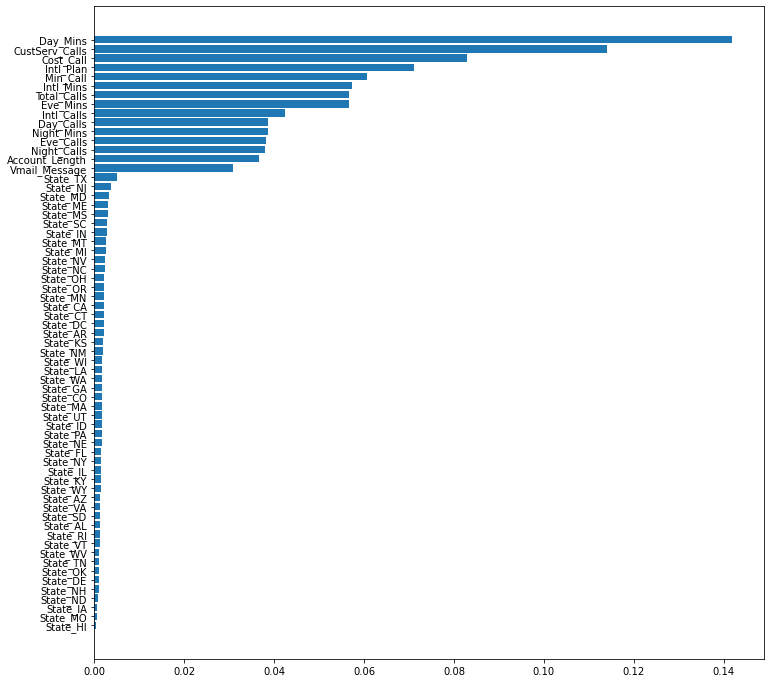

In [0]:
# Calculate feature importances
importances = grid_search.best_estimator_.feature_importances_
# Sort importances
sorted_index = np.argsort(importances)
# Create labels
labels = X.columns[sorted_index]
# Create plot
plt.figure(figsize=(12,12))
plt.barh(range(X.shape[1]), importances[sorted_index], tick_label=labels)
plt.show()

### Gradient Boosing Trees

In [0]:
def modelfit(alg, xtrain, xtest, ytrain, ytest, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(xtrain.values, label=ytrain.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics={"auc"}, early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(xtrain, ytrain, eval_metric='auc', verbose = True)
        
    #Predict training set:
    train_predictions = alg.predict(xtrain)
    train_predprob = alg.predict_proba(xtrain)[:,1]
    test_predprob = alg.predict_proba(xtest)[:,1]
    test_predictions = alg.predict(xtest)
        
    #Print model report:
    print ("\nModel Report")
    print ("AUC Score (Train): %f" % roc_auc_score(ytrain, train_predprob))
    global AUROC_XGB, Gini_XGB, F1_XGB 
    AUROC_XGB = roc_auc_score(ytest, test_predprob)
    print ("AUC Score (Test): {:.5f}".format(AUROC_XGB))
    Gini_XGB = AUROC_XGB * 2 - 1
    print ("Gini (Test): {:.5f}".format(Gini_XGB))
    F1_XGB = f1_score(ytest, test_predictions)
    print("F1 Score:", "{:.5f}".format(F1_XGB))
    print(confusion_matrix(ytest, test_predictions))
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
AUC Score (Train): 0.943949
AUC Score (Test): 0.92610
Gini (Test): 0.85220
F1 Score: 0.80460
[[563   3]
 [ 31  70]]


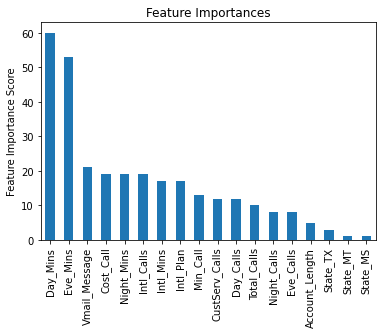

In [0]:
xgb1 = XGBClassifier(
 learning_rate = 0.1,
 n_estimators = 1000,
 max_depth = 5,
 min_child_weight = 1,
 gamma = 0,
 subsample = 0.8,
 colsample_bytree = 0.8,
 objective = 'binary:logistic',
 nthread = 4,
 scale_pos_weight = 1,
 seed = 27)

modelfit(xgb1, X_train, X_test, y_train, y_test)

Tune max_depth and min_child_weight

In [0]:
param_test1 = {
    'max_depth': range(3,10,2),
    'min_child_weight': range(1,6,2)
    }

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.1, n_estimators = 1000, max_depth = 5, min_child_weight = 1, gamma = 0, subsample = 0.8, 
                                                  colsample_bytree = 0.8, objective = 'binary:logistic', nthread = 4, scale_pos_weight = 1, seed = 27), 
                        param_grid = param_test1, scoring = 'roc_auc', n_jobs = 4, cv = 5)

gsearch1.fit(X_train, y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 1}, 0.9131241670916899)

Let's go one step deeper in the GridSearchCV

In [0]:
param_test2 = {
    'max_depth': [1, 2, 3, 4],
    'min_child_weight': [1, 2]
    }

gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.1, n_estimators = 1000, max_depth = 5, min_child_weight = 1, gamma = 0, subsample = 0.8, 
                                                  colsample_bytree = 0.8, objective = 'binary:logistic', nthread = 4, scale_pos_weight = 1, seed = 27), 
                        param_grid = param_test2, scoring = 'roc_auc', n_jobs = 4, cv = 5)

gsearch2.fit(X_train, y_train)
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 3, 'min_child_weight': 1}, 0.9131241670916899)

The optimum values are:
* max_depth: 3
* min_child_weight: 1


Model Report
AUC Score (Train): 0.950027
AUC Score (Test): 0.92877
Gini (Test): 0.85754
F1 Score: 0.77907
[[562   4]
 [ 34  67]]


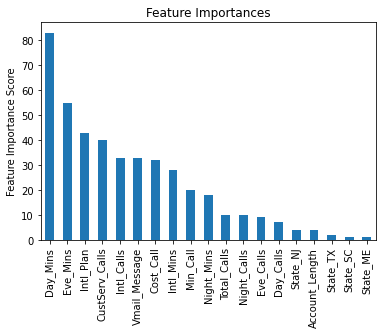

In [0]:
xgb2 = XGBClassifier(
 learning_rate = 0.1,
 n_estimators = 1000,
 max_depth = 3,
 min_child_weight = 1,
 gamma = 0,
 subsample = 0.8,
 colsample_bytree = 0.8,
 objective = 'binary:logistic',
 nthread = 4,
 scale_pos_weight = 1,
 seed = 27)

modelfit(xgb2, X_train, X_test, y_train, y_test)

Tune Gamma

In [0]:
param_test3 = {'gamma': [i/10.0 for i in range(0,5)]}

gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.1, n_estimators = 1000, max_depth = 3, min_child_weight = 1, gamma = 0, subsample = 0.8, 
                                                  colsample_bytree = 0.8, objective = 'binary:logistic', nthread = 4, scale_pos_weight = 1,seed = 27), 
                        param_grid = param_test3, scoring = 'roc_auc', n_jobs = 4, cv = 5)

gsearch3.fit(X_train, y_train)
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.3}, 0.9135794529091777)

The optimum values so far are:
* max_depth: 3
* min_child_weight: 1
* gamma: 0.3


Model Report
AUC Score (Train): 0.974727
AUC Score (Test): 0.93061
Gini (Test): 0.86121
F1 Score: 0.82682
[[562   4]
 [ 27  74]]


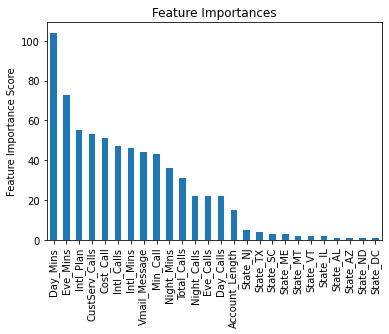

In [0]:
xgb3 = XGBClassifier(
 learning_rate = 0.1,
 n_estimators = 1000,
 max_depth = 3,
 min_child_weight = 1,
 gamma = 0.3,
 subsample = 0.8,
 colsample_bytree = 0.8,
 objective = 'binary:logistic',
 nthread = 4,
 scale_pos_weight = 1,
 seed = 27)

modelfit(xgb3, X_train, X_test, y_train, y_test)

Tune subsample and colsample_bytree

In [0]:
param_test4 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
    }

gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.1, n_estimators = 1000, max_depth = 3, min_child_weight = 1, gamma = 0.3, 
                                                  subsample = 0.8, colsample_bytree = 0.8, objective = 'binary:logistic', nthread = 4, 
                                                  scale_pos_weight = 1,seed = 27), 
                        param_grid = param_test4, scoring = 'roc_auc', n_jobs = 4, cv = 5)

gsearch4.fit(X_train, y_train)
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.7, 'subsample': 0.9}, 0.915568312067218)

Now we should try values in 0.05 interval around these best parameters.

In [0]:
param_test4b = {
    'subsample':[i/100.0 for i in range(85, 100, 5)],
    'colsample_bytree':[i/100.0 for i in range(65, 80, 5)]
    }

gsearch4b = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.1, n_estimators = 1000, max_depth = 3, min_child_weight = 1, gamma = 0.3, 
                                                  subsample = 0.8, colsample_bytree = 0.8, objective = 'binary:logistic', nthread = 4, 
                                                  scale_pos_weight = 1,seed = 27), 
                        param_grid = param_test4b, scoring = 'roc_auc', n_jobs = 4, cv = 5)

gsearch4b.fit(X_train, y_train)
gsearch4b.best_params_, gsearch4b.best_score_

({'colsample_bytree': 0.7, 'subsample': 0.9}, 0.915568312067218)

The optimum values so far are:
* max_depth: 3
* min_child_weight: 1
* gamma: 0.3
* subsample: 0.9
* colsample_bytree: 0.7


Model Report
AUC Score (Train): 0.990471
AUC Score (Test): 0.93122
Gini (Test): 0.86244
F1 Score: 0.82682
[[562   4]
 [ 27  74]]


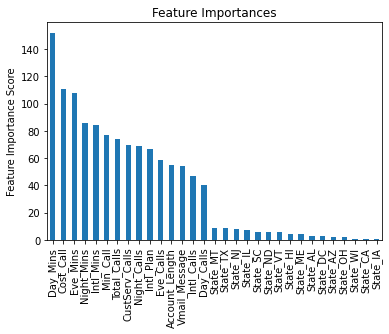

In [0]:
xgb4 = XGBClassifier(
 learning_rate = 0.1,
 n_estimators = 1000,
 max_depth = 3,
 min_child_weight = 1,
 gamma = 0.3,
 subsample = 0.9,
 colsample_bytree = 0.7,
 objective = 'binary:logistic',
 nthread = 4,
 scale_pos_weight = 1,
 seed = 27)

modelfit(xgb4, X_train, X_test, y_train, y_test)

Reducing Learning Rate and add more trees


Model Report
AUC Score (Train): 0.965794
AUC Score (Test): 0.93353
Gini (Test): 0.86705
F1 Score: 0.80226
[[561   5]
 [ 30  71]]


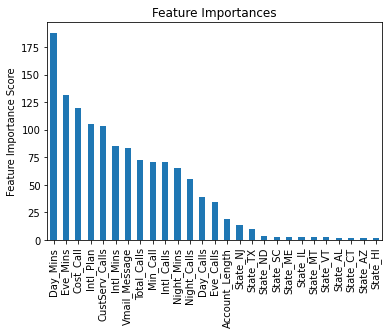

In [24]:
xgb5 = XGBClassifier(
 learning_rate = 0.05,
 n_estimators = 1000,
 max_depth = 3,
 min_child_weight = 1,
 gamma = 0.3,
 subsample = 0.9,
 colsample_bytree = 0.7,
 objective = 'binary:logistic',
 nthread = 4,
 scale_pos_weight = 1,
 seed = 27)

modelfit(xgb5, X_train, X_test, y_train, y_test)

Slight increase in AUC and Gini scores - so these will be our final parameters for XGBoost

## Summary of Validation Results

In [0]:
# Create Logistic Regression Series
LR_dict = {'AUROC' : AUROC_LR,
           'Gini' : Gini_LR,
           'F1' : F1_LR}
LR = pd.Series(LR_dict, name = "Logistic Regression")

# Create Decision Tree Series
DT_dict = {'AUROC' : AUROC_DT,
           'Gini' : Gini_DT,
           'F1' : F1_DT}
DT = pd.Series(DT_dict, name = "Decision Tree")

# Create Random Forest Series
RF_dict = {'AUROC' : AUROC_RF,
           'Gini' : Gini_RF,
           'F1' : F1_RF}
RF = pd.Series(RF_dict, name = "Random Forest")

# Create Random Forest - Parameterised Series
GRID_dict = {'AUROC' : AUROC_GRID,
           'Gini' : Gini_GRID,
           'F1' : F1_GRID}
GRID = pd.Series(GRID_dict, name = "Random Forest - GridSearchCV")

# Create XGBoost Series
XGB_dict = {'AUROC' : AUROC_XGB,
           'Gini' : Gini_XGB,
           'F1' : F1_XGB}
XGB = pd.Series(XGB_dict, name = "XGBoost")

summary_table = pd.concat([LR, DT, RF, GRID, XGB], axis = 1)
summary_table

,Logistic Regression,Decision Tree,Random Forest,Random Forest - GridSearchCV,XGBoost
AUROC,0.822359,0.854686,0.935521,0.936151,0.933527
Gini,0.644719,0.709373,0.871042,0.872302,0.867054
F1,0.257576,0.740385,0.704403,0.759036,0.802260


### Conclusion
From the above 4 models, Random Forest and XGBoost models are the clear winner. AUROC and Gini are marginally higher for the tuned Random Forest, while XGBoost's F1 Score is significantly better.

## Model Application

We can now determine the probability of our out-of-sample or new customers churning using any of the above models, segment our customers based on these probabilities and design and implement appropriate strategies accordingly.

Using xgb5 (our final XGBoost model) and its predicted probabilities based on the columns of the training dataset, we can determine churn probability of a new customer dataset as long as we have the same columns in the new dataset.

The following formula can be used to perform this:
* telco_new_customers['churn_probability'] = xgb5.predict_proba(telco[X_train.columns])[:,1]

We can then define and assign churn labels to each new customer. Our churn labels will be based on churn probabilities predicted in the formula noted above and can defined as below:

* Churners: probability > 0.5
* Potential Churners: 0.5 > probability > 0.25
* Non-Churners: probability < 0.25

Formulas to assing Churn Labels
* telco_new_customers['Churn Label'] = 'Non-Churner'
* telco_new_customers.loc[telco_new_customers['churn_probability'] > 0.25, 'Churn Label'] = 'Potential Churner' 
* telco_new_customers.loc[telco_new_customers['churn_probability'] > 0.5, 'Churn Label'] = 'Churner'